In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [4]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict(xvalid))


## 训练样本拆分

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train.text.values, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True
)
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


## TF-IDF

[API](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [6]:
tfv = TfidfVectorizer()
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [7]:
features = np.array(tfv.get_feature_names())
print('# of features:', len(features))

# of features: 25068


In [8]:
print(xtrain[1])
print(xtrain_tfv[1])
print(features[xtrain_tfv[1].nonzero()[1]])
features[14491]

"No," he said, "oh, no a member of my family my niece, and a most accomplished woman."
  (0, 24768)	0.3005102636889027
  (0, 19088)	0.20614527328621188
  (0, 15178)	0.29343338248504075
  (0, 15145)	0.07275183506625081
  (0, 14817)	0.3359495079496928
  (0, 14767)	0.43022586808278535
  (0, 14491)	0.24696931794488847
  (0, 14298)	0.21622339690853995
  (0, 13778)	0.37823189697350346
  (0, 10316)	0.13205783589396666
  (0, 8307)	0.28252340034711976
  (0, 837)	0.07430753809457315
  (0, 152)	0.35250423479818466
['woman' 'said' 'oh' 'of' 'no' 'niece' 'my' 'most' 'member' 'he' 'family'
 'and' 'accomplished']


'my'

In [9]:
idf_max, idf_min = tfv.idf_.argmax(), tfv.idf_.argmin()
np.array(tfv.get_feature_names())[[idf_max, idf_min]]

array(['aaem', 'the'], dtype='<U19')

train set: logloss: 0.311
valid set: logloss: 0.488
train set
              precision    recall  f1-score   support

         EAP      0.938     0.960     0.949      7110
         HPL      0.961     0.948     0.954      5071
         MWS      0.955     0.938     0.946      5440

    accuracy                          0.950     17621
   macro avg      0.951     0.949     0.950     17621
weighted avg      0.950     0.950     0.950     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.810     0.873     0.840       790
         HPL      0.845     0.824     0.835       564
         MWS      0.854     0.786     0.819       604

    accuracy                          0.832      1958
   macro avg      0.837     0.828     0.831      1958
weighted avg      0.834     0.832     0.832      1958



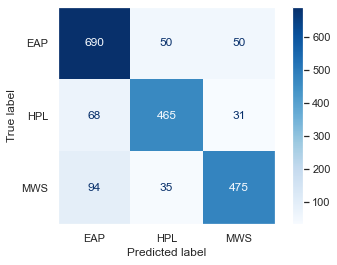

In [10]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'Basic BoW + TFIDF',
    xtrain_tfv, ytrain,
    xvalid_tfv, yvalid,
)

train set: logloss: 0.307
valid set: logloss: 0.487
train set
              precision    recall  f1-score   support

         EAP      0.941     0.964     0.953      7110
         HPL      0.964     0.950     0.957      5071
         MWS      0.958     0.940     0.949      5440

    accuracy                          0.953     17621
   macro avg      0.954     0.951     0.953     17621
weighted avg      0.953     0.953     0.953     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.809     0.875     0.841       790
         HPL      0.853     0.823     0.838       564
         MWS      0.846     0.785     0.814       604

    accuracy                          0.832      1958
   macro avg      0.836     0.827     0.831      1958
weighted avg      0.833     0.832     0.832      1958



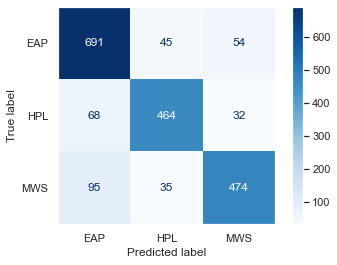

In [11]:
tfv = TfidfVectorizer(binary=True)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'Binary BoW + TFIDF',
    xtrain_tfv, ytrain,
    xvalid_tfv, yvalid,
)

In [12]:
history

train            validate          
                     logloss  accuracy   logloss  accuracy
Basic BoW + TFIDF   0.310889  0.948573  0.488013  0.828103
Binary BoW + TFIDF  0.306860  0.951430  0.487156  0.827382